<a href="https://colab.research.google.com/github/skylerlewis/nwca-comparison/blob/main/nwca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab setup
The code in this section is only needed for running the notebook on Google Colab. For running locally (e.g. Anaconda), comment out this section.
- Install packages that are not available on the Google server
- Authenticate with Google Drive credentials (follow on-screen prompt at first run)
- Copy files from Google Drive to the active working directory

In [ ]:
# install packages in the virtual environment
!pip install -q pandas fiona shapely pyproj rtree pygeos
!pip install -q geopandas
!pip install -q rasterio rioxarray
!pip install -q cartopy
!pip install -q -U PyDrive

# import packages necessary for accessing files via Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user() # opens auth prompt the first time it's run
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def file_from_gdrive(filename, driveid):
    downloaded = drive.CreateFile({"id": driveid}) 
    downloaded.GetContentFile(filename)
    return filename

# mount files from Google Drive (after running, they will be accessible by filename without any path prefix)
file_from_gdrive("Site_comparison_2011_2016.csv", "1PoYS_fbE1lYwi3ydbpXKkuP8YqoBFjnf")
file_from_gdrive("Site_comparison_2011_2016_README.csv", "1G5l8L2FgM0EebEKbjy06OWdsfGs47i3c")
file_from_gdrive("Aggr_Ecoregions_2015.zip", "1UqUM1mrj6qptAxSY8c1OGc3zRP_p7bVM")
file_from_gdrive("SubDataset_NWCA_2011.csv", "1QFbR0NoFo7go9hXp690yvb1_G-FjJTUV")
file_from_gdrive("RS_stability_NDVI_7_15_21.csv", "1-0dqvcgYokChh0dVZS8f7S7AfHVXr5pE")
# alternately, mount Google Drive and access via "/content/drive/MyDrive/" + path within drive

# Package imports and dependencies

In [2]:
# import basics
import os
import datetime as dt
from functools import reduce
import urllib
import io

# import data structures packages
import numpy as np      # matrix algebra / n-dim arrays 
import pandas as pd     # indexed data frames
import xarray as xr     # indexed multidimensional arrays

# pandas settings and shortcuts
from pandas import IndexSlice as idx
pd.set_option("display.precision", 2)
pd.set_option("display.float_format", '{:0.2f}'.format)

# import plotting packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# display plot output inline when running notebook
%matplotlib inline

# If running via Anaconda on Windows, reference the locations of the gdal dependencies (GDAL_DATA) and the pyproj projections library (PROJ_LIB) prior to importing the spatial packages
# os.add_dll_directory(r"C:\Users\skylerlewis\anaconda3\envs\geo2\Library\share\gdal")
# os.add_dll_directory(r"C:\Users\skylerlewis\anaconda3\envs\geo2\Library\include\boost\geometry\srs\projections\proj") 

# import geospatial data packages
import shapely              # vector geometries
import geopandas as gpd     # extends spatial/vector to pandas  
import rasterio as rio      # raster input/output
import rioxarray            # extends spatial/raster to xarray
from fiona.io import ZipMemoryFile

# define global coordinate reference system
global_crs = "EPSG:5070"    # NAD83 CONUS ALBERS
# to reproject geopandas feature layers, use method .to_crs(global_crs)
# to reproject xarray rasters, use method .rio.reproject(global_crs)

# import statistics packages
import scipy.stats      # assorted stats functions
import patsy            # converts R-style formulas to regression design matrix
import statsmodels.api as sm                # linear models via design matrix
import statsmodels.formula.api as smf       # linear models via R-style formula
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, median_absolute_error, mean_squared_log_error
from sklearn.decomposition import PCA

# import spatial statistics and plotting packages
import cartopy
# import pysal
# from libpysal.weights import lat2W, KNN
# from esda.moran import Moran

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Custom colormaps
These are some go-to colormaps that I often use for plotting.

To flip order, use `.reversed()` method, e.g. `plot(..., cmap=diverging_cmap.reversed())`


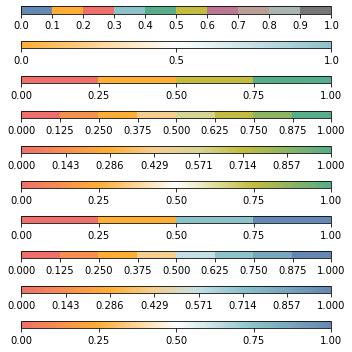

In [3]:
sstone_colors = ["#6388B4", "#FFAE34", "#EF6F6A", "#8CC2CA", 
                 "#55AD89", "#C3BC3F", "#BB7693", "#BAA094",
                 "#A9B5AE", "#767676"]
sstone = mpl.colors.ListedColormap(sstone_colors, name="Superfischel Stone")

diverging_cmap = mpl.colors.LinearSegmentedColormap.from_list(name="vlag_custom", colors=["#FFAE34", "#FFFFFF", "#8CC2CA"])

# orange-green diverging palettes
diverging_og_colors = ["#EF6F6A", "#F78F4F", "#FFAE34", "#F5CE90", 
                       "#D7D595", "#C3BC3F", "#8CB564", "#55AD89"]
diverging_og_4 = mpl.colors.ListedColormap(["#EF6F6A", "#FFAE34", "#C3BC3F", "#55AD89"], name="Orange-Green Diverging Categorical 4")
diverging_og_8 = mpl.colors.ListedColormap(diverging_og_colors, name="Orange-Green Diverging Categorical 8")
diverging_og_c = mpl.colors.LinearSegmentedColormap.from_list(colors=diverging_og_colors, name="Orange-Green Diverging Continuous")
diverging_og_cw = mpl.colors.LinearSegmentedColormap.from_list(colors=["#EF6F6A", "#FFAE34", "#FFFFFF", "#C3BC3F", "#55AD89"], name="Orange-Green Diverging Continuous through white")

# orange-blue diverging palettes
diverging_ob_colors = ["#EF6F6A", "#F78F4F", "#FFAE34", "#F5CE90", 
                       "#C5E0E4", "#8CC2CA", "#78A5BF", "#6388B4"]
diverging_ob_4 = mpl.colors.ListedColormap(["#EF6F6A", "#FFAE34", "#8CC2CA", "#6388B4"], name="Orange-Blue Diverging Categorical 4")
diverging_ob_8 = mpl.colors.ListedColormap(diverging_ob_colors, name="Orange-Blue Diverging Categorical")
diverging_ob_c = mpl.colors.LinearSegmentedColormap.from_list(colors=diverging_ob_colors, name="Orange-Blue Diverging Continuous")
diverging_ob_cw = mpl.colors.LinearSegmentedColormap.from_list(colors=["#EF6F6A", "#FFAE34", "#FFFFFF", "#8CC2CA", "#6388B4"], name="Orange-Blue Diverging Continuous through white")

# plot previews of all these colormaps
fig, ax = plt.subplots(10, figsize=(5,5))
mpl.colorbar.ColorbarBase(ax=ax[0], cmap=plt.get_cmap(sstone),          orientation="horizontal", ticks=np.linspace(0, 1, 11))
mpl.colorbar.ColorbarBase(ax=ax[1], cmap=plt.get_cmap(diverging_cmap), orientation="horizontal", ticks=np.linspace(0, 1, 3))
mpl.colorbar.ColorbarBase(ax=ax[2], cmap=plt.get_cmap(diverging_og_4),  orientation="horizontal", ticks=np.linspace(0, 1, 5))
mpl.colorbar.ColorbarBase(ax=ax[3], cmap=plt.get_cmap(diverging_og_8),  orientation="horizontal", ticks=np.linspace(0, 1, 9))
mpl.colorbar.ColorbarBase(ax=ax[4], cmap=plt.get_cmap(diverging_og_c),  orientation="horizontal", ticks=np.linspace(0, 1, 8))
mpl.colorbar.ColorbarBase(ax=ax[5], cmap=plt.get_cmap(diverging_og_cw), orientation="horizontal", ticks=np.linspace(0, 1, 5))
mpl.colorbar.ColorbarBase(ax=ax[6], cmap=plt.get_cmap(diverging_ob_4),  orientation="horizontal", ticks=np.linspace(0, 1, 5))
mpl.colorbar.ColorbarBase(ax=ax[7], cmap=plt.get_cmap(diverging_ob_8),  orientation="horizontal", ticks=np.linspace(0, 1, 9))
mpl.colorbar.ColorbarBase(ax=ax[8], cmap=plt.get_cmap(diverging_ob_c),  orientation="horizontal", ticks=np.linspace(0, 1, 8))
mpl.colorbar.ColorbarBase(ax=ax[9], cmap=plt.get_cmap(diverging_ob_cw), orientation="horizontal", ticks=np.linspace(0, 1, 5))
plt.tight_layout()
plt.show()

# Custom functions

General-purpose functions used in multiple places.

In [4]:
def unzip_shapefile(filename: str) -> gpd.GeoDataFrame:

    """ Return a geodataframe from a zipped shapefile"""
    
    zipshp = io.BytesIO(open(filename, "rb").read())
    with (ZipMemoryFile(zipshp)) as memfile:
        with memfile.open() as src:
            crs = src.crs
            gdf = gpd.GeoDataFrame.from_features(src, crs=crs)
    return gdf

def subset_by_sindex(target_features: gpd.GeoDataFrame, 
                     by_features: gpd.GeoDataFrame, 
                     predicate: str="intersects") -> gpd.GeoDataFrame:

    """ Returns a subset of features in target_features
        according to relationship with features in by_features.
        Predicate is one of ['intersects', 'within', 'contains', 'overlaps', 'crosses', 'touches'] 
        When possible, 'within' and 'contains' are much faster than 'intersects' """

    inp, res = by_features.sindex.query_bulk(target_features.geometry, predicate=predicate)
    return target_features[np.isin(np.arange(0, len(target_features)), inp)]

def gen_cmap(palette: list, name: str = "custom") -> mpl.colors.LinearSegmentedColormap:
    
    """ Returns a discrete segmented matplotlib colormap given a list of color strings."""

    colors = [(i / (len(palette) - 1), x) for i, x in enumerate(palette)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list("custom", colors, len(palette))
    return cmap

def make_ellipse(x: np.ndarray, y: np.ndarray, n_std=3.0, type="confidence", **kwargs) -> mpl.patches.Ellipse:

    """ Generates a standard deviation ellipse to describe the shape of data in two dimensions.
        Add the result to a plot using ax.add_patch(ellipse) """
    x, y = pd.DataFrame(np.concatenate([[x.flatten()], [y.flatten()]], axis=0)).dropna(axis=1).to_numpy()
    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    if type == "confidence":
        q = 2 * scipy.stats.norm.cdf(n_std) - 1
        r2 = scipy.stats.chi2.ppf(q, 2)
        width, height = 2 * np.sqrt(vals * r2)
    elif type == "error":
        width, height = 2 * n_std * np.sqrt(vals)
    # center of ellipse
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    # create ellipse
    ellipse = mpl.patches.Ellipse(xy=(mean_x, mean_y), 
                                  width=width, height=height, angle=theta, **kwargs)
    return ellipse

def flatten_columns(df: pd.DataFrame) -> pd.DataFrame:

    """ If a dataframe's columns are a multi-level index, 
        returns a dataframe with a simple single-level index. """
        
    d = df.copy()
    if d.columns.nlevels > 1:
        d.columns = ['_'.join(tup).rstrip('_') for tup in d.columns.values]
    else:
        pass
    return d.rename_axis(["varname"], axis="columns")

def pca(X: pd.DataFrame, n_components: int=2, stem: str="", join: bool=False) -> pd.DataFrame:

    """ Returns a dataframe with columns transformed via PCA. """

    X_cleaned = X.dropna()
    pc = pd.DataFrame(PCA(n_components=2).fit_transform(X_cleaned), index=X_cleaned.index)
    pc.columns = [stem + str(i) for i in pc.columns]
    joined = X.join(pc, how="left")
    if join:
        return joined
    else:
        return joined[pc.columns]

# Data import

## CSV Data
In this section, we import and transform multiple tabular data sources into a single DataFrame called `sites`. 

This is also where I am log-transforming relevant variables. Keeping this all in one notebook codeblock since we are internally modifying the `sites` dataframe. However, the histograms for looking at variable distributions are farther down.

In [5]:
######################################
# 2011/2016 TRAITS & DIVERSITY DATASET
######################################

# import data
sites = pd.read_csv("Site_comparison_2011_2016.csv")
readme = pd.read_csv("Site_comparison_2011_2016_README.csv")

# convert to pandas dataframe with multiindex columns (varname, year) derived from readme file
if (sites.columns == readme["trait"]).all():
    sites.columns = pd.MultiIndex.from_tuples(zip(readme["varname"], readme["year"]), names=["varname", "year"])
else:
    raise ValueError("Make sure the list of variables in both files matches!")

# set row index to multiindex (2011 uid, 2016 uid)
sites = sites.set_index([("UID", "2011"), ("UID", "2016")]).rename_axis(["UID11", "UID16"])

# create order for wetland types
wetlandtypes = ["PFO", "PSS", "PEM", "PUBPAB", "E2SS", "E2EM"]
typecolors = ["#55AD89", "#C3BC3F", "#FFAE34", "#BAA094", "#8CC2CA", "#6388B4"]
sites[("WetlandType", "2011")] = ["PFO" if x=="PF" else x for x in sites[("WetlandType", "2011")]]
sites[("WetlandType", "2016")] = ["PFO" if x=="PF" else x for x in sites[("WetlandType", "2016")]]
sites[("WetlandType", "2011")] = sites[("WetlandType", "2011")].astype("category").cat.set_categories(wetlandtypes)
sites[("WetlandType", "2016")] = sites[("WetlandType", "2016")].astype("category").cat.set_categories(wetlandtypes)

# wetland general categories
wetlandcats = ["EH", "EW", "PRLH", "PRLW"] # Estuarine herbaceous & woody, Palustrine/Riverine/Lacustrine herbaceous & woody
catcolors = ["#8CC2CA", "#6388B4", "#C3BC3F", "#55AD89"]
sites[("WetlandCat", "2011")] = ["EH" if x=="E2EM" else "EW" if x=="E2SS" else "PRLH" if x in ["PEM", "PUBPAB"] else "PRLW" if x in ["PFO", "PSS"] else None for x in sites[("WetlandType", "2011")]]
sites[("WetlandCat", "2011")] = sites[("WetlandCat", "2011")].astype("category").cat.set_categories(wetlandcats)
sites[("WetlandCat", "2016")] = ["EH" if x=="E2EM" else "EW" if x=="E2SS" else "PRLH" if x in ["PEM", "PUBPAB"] else "PRLW" if x in ["PFO", "PSS"] else None for x in sites[("WetlandType", "2011")]]
sites[("WetlandCat", "2016")] = sites[("WetlandCat", "2016")].astype("category").cat.set_categories(wetlandcats)

# create dummies for estuarine and woody
#sites["WetlandCat"].applymap(lambda x: x[-1]=="W")
#sites["WetlandCat"].applymap(lambda x: x[:-1]=="E")
for yr in ["2011", "2016"]:
    sites[("d_estuarine", yr)] = np.where(sites[("WetlandCat", yr)].apply(lambda x: x[:-1]=="E"), 1, 0)
    sites[("d_woody", yr)] = np.where(sites[("WetlandCat", yr)].apply(lambda x: x[-1]=="W"), 1, 0)
    # total coverage and proportion of which is native
    sites[("XRCOV", yr)] = sites[("XRCOV_NATSPP", yr)] + sites[("XRCOV_ALIENSPP", yr)] 
    sites[("XRCOV_PropNative", yr)] = sites[("XRCOV_NATSPP", yr)] / np.where(sites[("XRCOV", yr)] > 0, sites[("XRCOV", yr)], np.nan) * 100
    sites[("XRCOV_PropNonNative", yr)] = [100 - x for x in sites[("XRCOV_PropNative", yr)]]
    sites[("XN_PropNative", yr)] = sites[("XN_NATSPP", yr)] / sites[("XN_NATSPP", yr)].add(sites[("XN_ALIENSPP", yr)]) * 100
    sites[("XN_PropNonNative", yr)] = sites[("XN_ALIENSPP", yr)] / sites[("XN_NATSPP", yr)].add(sites[("XN_ALIENSPP", yr)]) * 100
sites[("XN_PropNonNative", "DIFF")] = sites[("XN_PropNonNative", "2016")] - sites[("XN_PropNonNative", "2011")]

# logs of variables that are right tailed
vars_to_log = ["NSPP", "SLA_Mean", "AnaerobicTol_Mean", "CN_Ratio", "XN_NATSPP", "XN_ALIENSPP", "XRCOV_ALIENSPP", "SLA_Variance", "XN_PropNonNative", "XRCOV_PropNonNative"]
for v in vars_to_log:
    for y in ["2011", "2016"]:
        sites[(f"log_{v}", y)] = np.where(sites[v, y]>0, np.log(sites[v, y]), np.nan)
    sites[(f"log_{v}", "DIFF")] = sites[(f"log_{v}", "2016")] - sites[(f"log_{v}", "2011")]

##############################
# 2011 ADDITIONAL NWCA DATASET
##############################
ds11 = pd.read_csv("SubDataset_NWCA_2011.csv").set_index("UID").rename_axis("UID11")
ds11.columns = pd.MultiIndex.from_tuples([(x, "2011") for x in ds11.columns])
sites = sites.join(ds11, how="left")

# create dummies for disturbance level, and also change it to an ordered category
sites[("REF_NWCA", "2011")] = sites[("REF_NWCA", "2011")].astype("category").cat.set_categories(["L", "I", "M"])#.cat.rename_categories(["Least", "Intermediate", "Most"])
sites[("d_disturb_L", "2011")] = np.where(sites[("REF_NWCA", "2011")]=="L", 1, 0)
sites[("d_disturb_I", "2011")] = np.where(sites[("REF_NWCA", "2011")]=="I", 1, 0)
sites[("d_disturb_M", "2011")] = np.where(sites[("REF_NWCA", "2011")]=="M", 1, 0)

##################################
# REMOTE SENSING STABILITY DATASET
##################################
dsstab = pd.read_csv("RS_stability_NDVI_7_15_21.csv").set_index("siteID").rename_axis("UID11")
dsstab.columns = pd.MultiIndex.from_tuples([(x, "") for x in dsstab.columns])
sites = sites.join(dsstab, how="left")

# harmonic means of mean:variance ratios for NDVI (avg values derived from 3 platforms)
sites[("MV_all_Mean", "")] = 3 / (1/sites["MV_ModTerra_Mean"] + 1/sites["MV_ModAqua_Mean"] + 1/sites["MV_Landsat_Mean"])
sites[("MV_all_Max", "")] = 3 / (1/sites["MV_ModTerra_Max"] + 1/sites["MV_ModAqua_Max"] + 1/sites["MV_Landsat_Max"])

# log variables with skewed distributions
sites[("log_pheno_var", "")] = np.log(sites["pheno_var"])
sites[("log_MaxPSD", "")] = np.log(sites["MaxPSD"])
sites[("log_MV_all_Mean", "")] = np.log(sites["MV_all_Mean"])
sites[("log_MV_all_Max", "")] = np.log(sites["MV_all_Max"])

# add principal components for traits
X = flatten_columns(sites)[["log_AnaerobicTol_Mean_DIFF", "log_CN_Ratio_DIFF", "log_SLA_Mean_DIFF"]]
sites[("trait_dif_pc1", "")], sites[("trait_dif_pc2", "")] = zip(*pca(X, n_components=2).values)

# add principal components for diversity
X = flatten_columns(sites)[["log_NSPP_DIFF", "ShannonDiv_DIFF"]]
sites[("diversity_dif_pc1", "")], sites[("diversity_dif_pc2", "")] = zip(*pca(X, n_components=2).values)

sites

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

varname      Latitude Longitude  ... diversity_dif_pc1 diversity_dif_pc2
year             2011      2011  ...                                    
UID11 UID16                      ...                                    
2610  204253    30.15    -85.04  ...             -0.03              0.32
2611  201075    32.53    -80.45  ...              0.25             -0.15
2669  197720    29.66    -81.77  ...             -0.25              0.03
2791  200920    32.39    -80.66  ...             -0.42              0.07
2812  197200    30.26    -87.73  ...             -0.09             -0.43
...               ...       ...  ...               ...               ...
5910  209080    47.55    -95.59  ...              0.08             -0.09
5911  204792    44.86    -72.05  ...             -0.06             -0.08
5912  202530    43.91    -73.10  ...              1.20             -0.84
5915  202530    43.91    -73.10  ...              0.69             -0.49
6146  201931    31.56    -81.67  ...              1.04             -0.60

[293 rows x 173 columns]

The MultiIndex functionalities in `pandas` are useful for keeping organized.
- Rows are identified by both the 2011 and 2016 UIDs. 
    - Since 2011 UID is first, it can be used for simple indexing e.g. `sites.loc[2610]` or `sites.loc[5910:6146]`.
    - Either can be used for joining additional datasets, as long as the index axis in the source data is called `UID11` or `UID16`.
- Columns are identified by the variable name and the year (`2011`, `2016`, or `DIFF`), e.g. `sites[['WetlandType', '2016']]`. 
    - For variables that are not identified by year, the year portion of the column name is left blank. 
    - To reshape with one row per observation per year, just use `sites.stack("year")`.
    - To select only variables for a certain year, use e.g. `sites.stack().loc[idx[:, :, "2011"]]`
    - For purposes where the multiple levels of columns complicate coding, use `flatten_columns(sites)` to reference columns with simple string names separated by underscore, e.g. `flatten_columns(sites)["WetlandType_2016"]`.

## Spatial Data
Next, we use the lat/lon coordinates to set up the spatial dataframe, and also import and join the EPA ecoregions.**bold text**

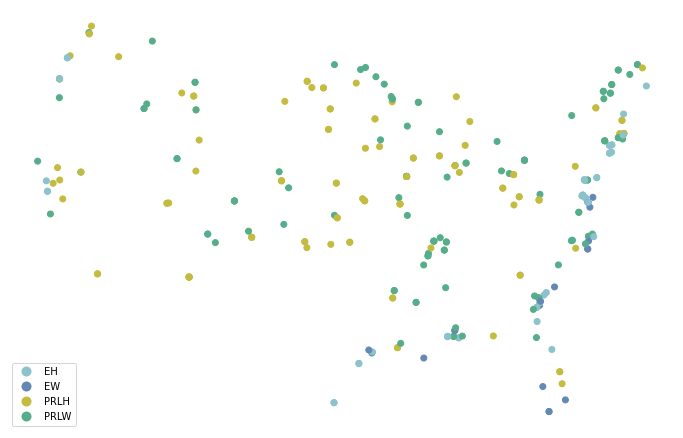

In [6]:
# convert 2016 longitude to points
site_locs = gpd.GeoSeries(gpd.points_from_xy(sites[("Longitude", "2016")], sites[("Latitude", "2016")]), 
                          index=sites.index).set_crs("EPSG:4269").to_crs(global_crs)

# create geodataframe
sites_gdf = gpd.GeoDataFrame(flatten_columns(sites), geometry=site_locs)

# plot result
fig, ax = plt.subplots()
sites_gdf.plot(column="WetlandCat_2016", legend=True, cmap=gen_cmap(catcolors), ax=ax)
ax.axis("off")
fig.set_size_inches(12, 12)
plt.show()

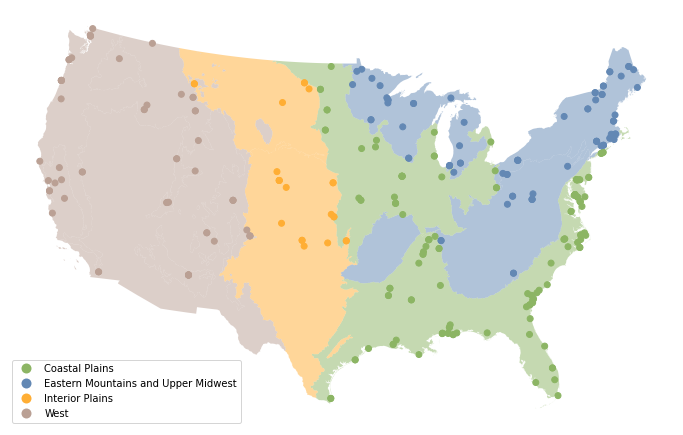

In [7]:
# import EPA ecoregions shapefile
ecoregions = unzip_shapefile("Aggr_Ecoregions_2015.zip").to_crs(global_crs)

# convert from 9-level to 4-level ecoregions per EPA defintions
ecoregions["WSA4"] = ["EMU" if x in ["NAP", "SAP", "UMW"]
                        else "IPL" if x in ["NPL", "SPL"]
                        else "W" if x in ["XER", "WMT"]
                        else "CPL" for x in ecoregions["WSA9"]]

# defne full names
full_names = {
    "CPL": "Coastal Plains", 
    "EMU": "Eastern Mountains and Upper Midwest",
    "IPL": "Interior Plains",
    "W": "West",
}
ecoregions["WSA4_NAME"] = [full_names[x] for x in ecoregions["WSA4"]]

# define category orders
region_names = ["CPL", "EMU", "IPL", "W"]
region_colors = ["#8CB564", "#6388B4", "#FFAE34", "#BAA094"]
ecoregions["WSA4"] = ecoregions["WSA4"].astype("category").cat.set_categories(region_names)
ecoregions["WSA4_NAME"] = ecoregions["WSA4_NAME"].astype("category").cat.set_categories(full_names.values())

# spatially join with sites_gdf and add add as a column to sites
site_ecoregions = gpd.sjoin(sites_gdf, ecoregions, how="left", op="within")[["geometry", "WSA4", "WSA4_NAME", "WSA9", "WSA9_NAME"]]
sites["ecoregion"] = site_ecoregions["WSA4_NAME"].copy()
sites_gdf["ecoregion"] = site_ecoregions["WSA4_NAME"].copy()

# plot ecoregions by site
fig, ax = plt.subplots()
ecoregions.plot(column="WSA4_NAME", ax=ax, alpha=0.5, cmap=gen_cmap(region_colors))
site_ecoregions.plot(column="WSA4_NAME", ax=ax, legend=True, cmap=gen_cmap(region_colors))
ax.axis("off")
fig.set_size_inches(12, 12)
plt.show()

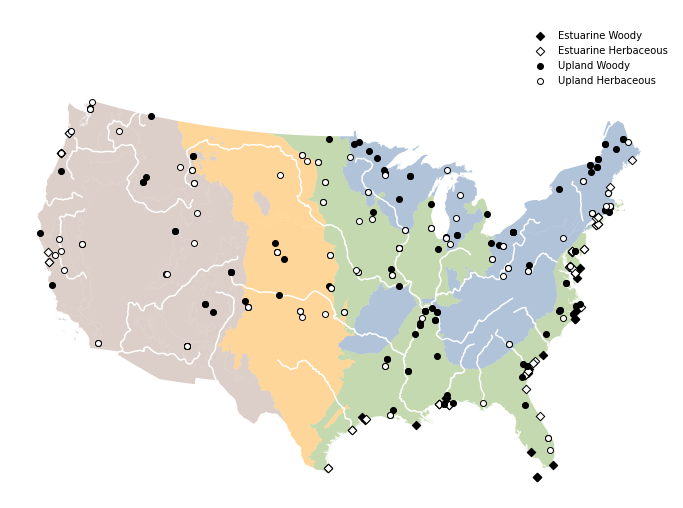

In [8]:
# import Natural Earth (naturalearthdata.com) shapefiles for major rivers
rivers = cartopy.io.shapereader.natural_earth(
        resolution="50m",
        category="physical",
        name="rivers_lake_centerlines")
rivers = gpd.read_file(rivers).to_crs(global_crs)
bbx = gpd.GeoSeries(shapely.geometry.box(-124.848974, 24.396308, -66.885444, 49.384358)).set_crs("EPSG:4326").to_crs(global_crs)
xmin, ymin, xmax, ymax = bbx.total_bounds
rivers = rivers["geometry"].explode().cx[xmin:xmax, ymin:ymax]

# plot wetlands by ecoregion and wetland type
fig, ax = plt.subplots()
ecoregions.plot(column="WSA4_NAME", ax=ax, alpha=0.5, cmap=gen_cmap(region_colors), legend=True, zorder=0)
rivers.plot(ax=ax, color="white", zorder=1)
leg = ax.get_legend()
flatten_columns(sites_gdf).query("d_estuarine_2011==1 & d_woody_2011==1")["geometry"].plot(ax=ax, edgecolor="black", facecolor="black", marker="D")
flatten_columns(sites_gdf).query("d_estuarine_2011==1 & d_woody_2011==0")["geometry"].plot(ax=ax, edgecolor="black", facecolor="white", marker="D")
flatten_columns(sites_gdf).query("d_estuarine_2011==0 & d_woody_2011==1")["geometry"].plot(ax=ax, edgecolor="black", facecolor="black", marker="o")
flatten_columns(sites_gdf).query("d_estuarine_2011==0 & d_woody_2011==0")["geometry"].plot(ax=ax, edgecolor="black", facecolor="white", marker="o")
ax.legend(["", "Estuarine Woody", "Estuarine Herbaceous", "Upland Woody", "Upland Herbaceous"], frameon=False)
ax.axis("off")
fig.set_size_inches(12, 12)
plt.show()

## TerraClimate
[TerraClimate](https://www.nature.com/articles/sdata2017191) provides a long-term time series of climate and water balance data, and is accessible for subset and download via the NetCDFsubset API. In this section, we query a series of variables within the bounding box of the continental US. The time frame is 2007-2016, the same as is used for the remote sensing variables. Full catalog is [here](http://thredds.northwestknowledge.net:8080/thredds/catalog/TERRACLIMATE_ALL/data/catalog.html):
- **`ppt`** = precipitation
- **`pet`** = potential evapotranspiration (ETo)
- **`aet`** = actual evapotranspiration
- **`def`** = [climate water balance](https://www.fs.fed.us/psw/cirmount/meetings/agu/pdf2011/Stephenson_talk_AGU2011.pdf) = `pet` - `aet`
- **`PDSI`** = Palmer Drought Severity Index

The multidimensional gridded raster data is delivered in NetCDF format,  which is handled in Python using the `xarray` package (`rioxarray` extends this to allow spatial referencing and projection with the `.rio` methods.) Then, for each point, we extract the full time series at the corresponding grid location, and the output becomes a new dataframe.

In [9]:
# extracting values takes about 30 seconds for each var/year in addition to download time (~100 MB each)
def extract_values_to_points(ds: xr.Dataset, varname: str, pts: gpd.GeoSeries) -> pd.DataFrame:
    def timeseries_from_raster(pt: shapely.geometry.Point) -> pd.Series:
        return ds.sel(lon=pt.x, lat=pt.y, method="nearest").to_dataframe()[varname]
    return pts.apply(timeseries_from_raster).stack().rename(varname)

# define parameters of files to get
tc_vars = ["ppt", "pet", "aet", "def", "PDSI"] 

# store the downloaded NetCDF files to a local folder
dirname = "tc"

# points at which to extract values
pts = sites_gdf.geometry.to_crs("EPSG:4326")

# loop through variables, download data, and extract values to points
d = {}
if not os.path.exists(dirname):
    os.mkdir(dirname)
for v in tc_vars:
    # URL for TerraClimate data over contiguous USA for 2007-2016
#    url = f"http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_terraclimate_{v}_1958_CurrentYear_GLOBE.nc?var={v}&north=51&west=-125&east=-67&south=24&disableProjSubset=on&horizStride=1&time_start=2007-01-01T00%3A00%3A00Z&time_end=2016-12-31T00%3A00%3A00Z&timeStride=1&accept=netcdf"
    url = f"http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_terraclimate_{v}_1958_CurrentYear_GLOBE.nc?var={v}&north=51&west=-125&east=-67&south=24&disableProjSubset=on&horizStride=1&time_start=2007-01-01T00:00:00Z&time_end=2016-12-31T00:00:00Z&timeStride=1&accept=netcdf"
    destname = os.path.join(dirname, f"TerraClimate_{v}.nc")
    if not os.path.exists(destname):
        urllib.request.urlretrieve(url, destname)
    with xr.open_dataset(destname).rio.write_crs("EPSG:4326").rio.set_spatial_dims(x_dim="lon", y_dim="lat") as ds:
        d[v] = extract_values_to_points(ds=ds, varname=v, pts=pts)

# transform and reindex
extracted = (pd.concat(d, names=["varname"])
        .rename("value")
        .unstack("varname")
        .assign(aridity = lambda d: np.where(d["pet"] > 0, d["ppt"] / d["pet"], np.nan))
        .reset_index()
        .assign(year = lambda d: [x.year for x in d["time"]])
        .set_index(["UID11", "UID16", "year", "time"])
)

# calculate intraannual statistics (incl. mean and std) for each site for each year in the time frame
tc_years = (extracted
        .groupby(["UID11", "UID16", "year"])
        #.agg(["min", "mean", "max", "std"])
        .agg(["mean", "std"])
        .pipe(flatten_columns)
)

# LOCAL CLIMATE (LONG TERM MEAN AND INTRA-ANNUAL VARIABILITY)
# average the intraannual stats over the whole time frame to get a characteristic 
# long-term avg mean (baseline climate control) and long-term avg std (intraannual variation)
tc_2007_16 = tc_years.groupby(["UID11", "UID16"]).mean()

# DIFFERENCE IN CLIMATE BETWEEN THE STUDY YEARS
# get the mean value and intraannual std for the 2011 and 2016, and calculate the difference 
tc_2011 = tc_years.loc[idx[:, :, 2011]]
tc_2016 = tc_years.loc[idx[:, :, 2016]]
tc_DIFF = tc_2016 - tc_2011

# rename and combine the results of the above calculations, and join to the sites dataframe
# the long-term average/std have year blank, while the others have 2011, 2016, DIFF
df_tc = (pd.concat([tc_2007_16.assign(year=""), 
                    tc_2011.assign(year="2011"), 
                    tc_2016.assign(year="2016"), 
                    tc_DIFF.assign(year="DIFF")
                    ], axis="rows")
        .set_index("year", append=True)
        .unstack()
)
sites = sites.join(df_tc, how="left")

# log-transformation of right-tailed variables (diff is taken after transform)
vars_to_log = ["def_mean", "def_std", "ppt_mean", "ppt_std"]
for v in vars_to_log:
    for y in ["", "2011", "2016"]:
        sites[(f"log_{v}", y)] = np.where(sites[v, y]>0, np.log(sites[v, y]), np.nan)
    sites[(f"log_{v}", "DIFF")] = sites[(f"log_{v}", "2016")] - sites[(f"log_{v}", "2011")]

# principal components of all climate variables (not currently using)

# X = flatten_columns(sites)[["ppt_mean", "def_mean", "aet_mean"]]
# climate_mean_pc = PCA(n_components=2).fit_transform(X)
# sites[("climate_mean_pc1", "")], sites[("climate_mean_pc2", "")] = zip(*climate_mean_pc)
# 
# X = flatten_columns(sites)[["ppt_std", "def_std", "aet_std"]]
# climate_std_pc = PCA(n_components=2).fit_transform(X)
# sites[("climate_std_pc1", "")], sites[("climate_std_pc2", "")] = zip(*climate_std_pc)
# 
# X = flatten_columns(sites)[["ppt_mean_DIFF", "def_mean_DIFF", "aet_mean_DIFF"]]
# climate_diff_pc = PCA(n_components=2).fit_transform(X)
# sites[("climate_diff_pc1", "")], sites[("climate_diff_pc2", "")] = zip(*climate_diff_pc)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Exploratory Plots

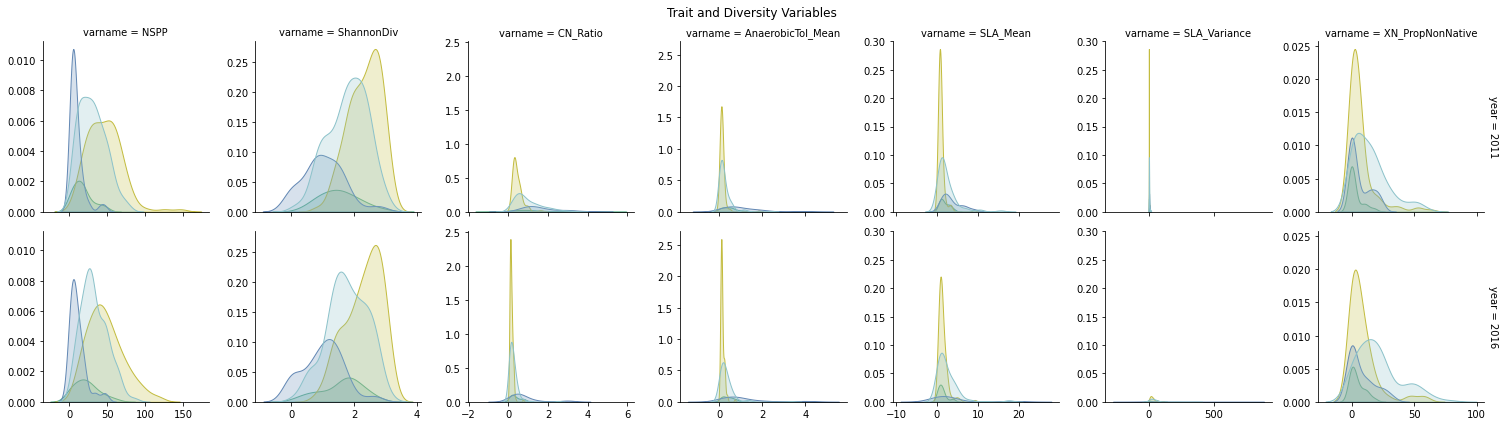

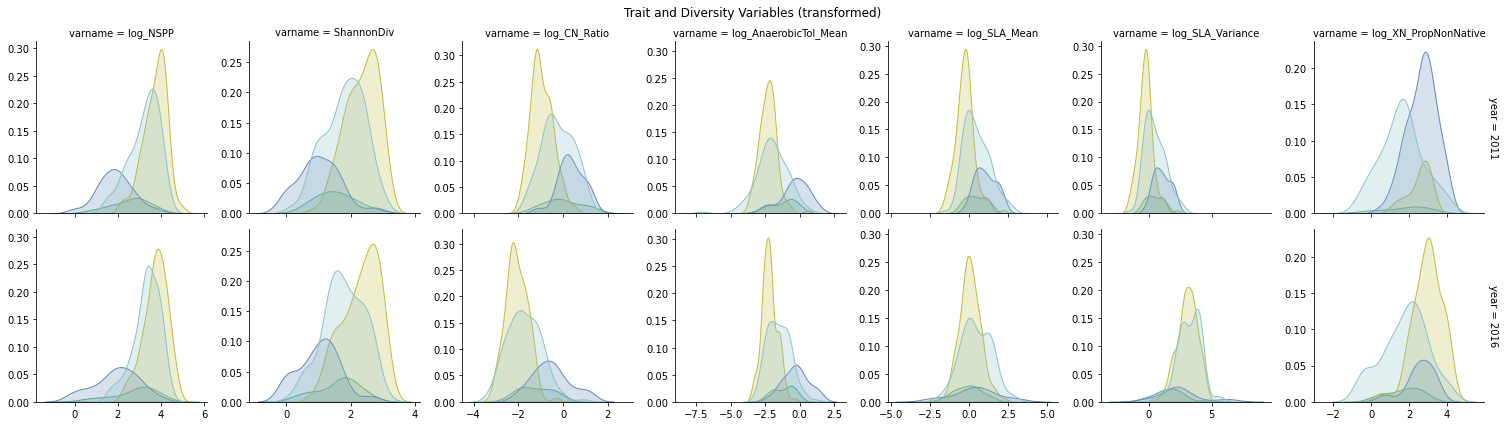

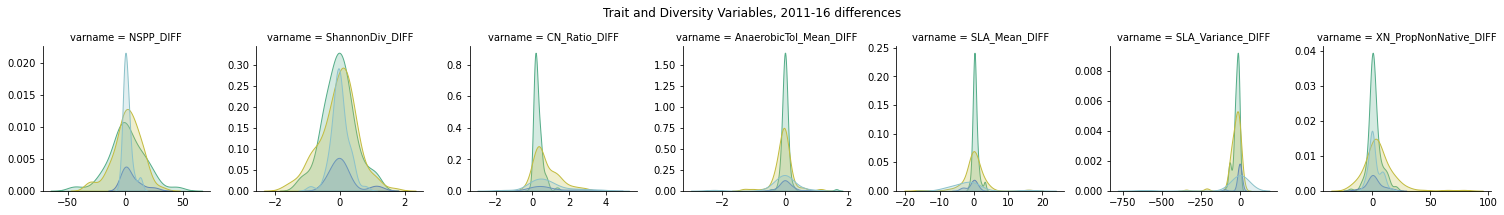

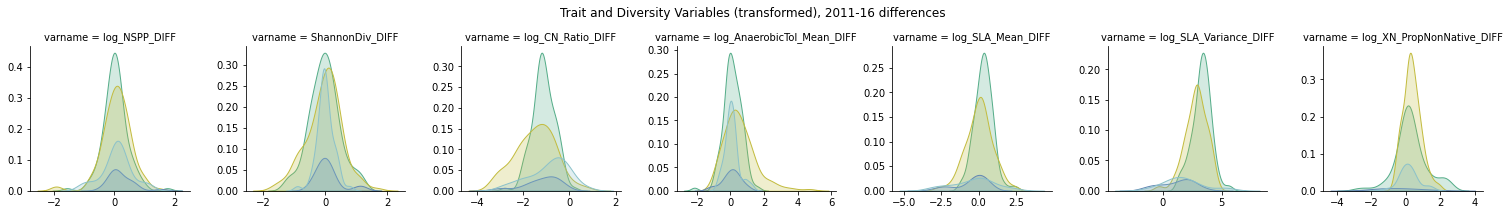

In [10]:
# Plot histograms of trait and diversity data from the comparison dataset
# for traditional histogram that's not colored by wetland type, comment out kdeplot line and uncomment histplot line

d = sites.stack("year").set_index("WetlandCat", append=True).loc[idx[:, :, "2011":"2016"]][["NSPP", "ShannonDiv", "CN_Ratio", "AnaerobicTol_Mean", "SLA_Mean", "SLA_Variance", "XN_PropNonNative", ]].stack("varname").rename("value").reset_index()
g = sns.FacetGrid(data=d, col="varname", row="year", sharex="col", sharey="col", margin_titles=True)
#g.map_dataframe(sns.histplot, x="value", bins=25, stat="density")
g.map_dataframe(sns.kdeplot, x="value", hue="WetlandCat", palette=catcolors, shade=True)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Trait and Diversity Variables")
plt.show()

d = sites.stack("year").set_index("WetlandCat", append=True).loc[idx[:, :, "2011":"2016"]][["log_NSPP", "ShannonDiv", "log_CN_Ratio", "log_AnaerobicTol_Mean", "log_SLA_Mean", "log_SLA_Variance", "log_XN_PropNonNative"]].stack("varname").rename("value").reset_index()
g = sns.FacetGrid(data=d, col="varname", row="year", sharex="col", sharey="col", margin_titles=True)
#g.map_dataframe(sns.histplot, x="value", bins=25, stat="density")
g.map_dataframe(sns.kdeplot, x="value", hue="WetlandCat", palette=catcolors, shade=True)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Trait and Diversity Variables (transformed)")
plt.show()

d = flatten_columns(sites).set_index("WetlandCat_2011", append=True)[["NSPP_DIFF", "ShannonDiv_DIFF", "CN_Ratio_DIFF", "AnaerobicTol_Mean_DIFF", "SLA_Mean_DIFF", "SLA_Variance_DIFF",  "XN_PropNonNative_DIFF"]].stack().rename("value").reset_index()
g = sns.FacetGrid(data=d, col="varname", sharex=False, sharey=False)
#g.map_dataframe(sns.histplot, x="value",bins=25, stat="density")
g.map_dataframe(sns.kdeplot, x="value", hue="WetlandCat_2011", palette=catcolors, shade=True)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Trait and Diversity Variables, 2011-16 differences")
plt.show()

d = flatten_columns(sites).set_index("WetlandCat_2011", append=True)[["log_NSPP_DIFF", "ShannonDiv_DIFF", "log_CN_Ratio_DIFF", "log_AnaerobicTol_Mean_DIFF", "log_SLA_Mean_DIFF", "log_SLA_Variance_DIFF",  "log_XN_PropNonNative_DIFF",]].stack().rename("value").reset_index()
g = sns.FacetGrid(data=d, col="varname", sharex=False, sharey=False)
#g.map_dataframe(sns.histplot, x="value",bins=25, stat="density")
g.map_dataframe(sns.kdeplot, x="value", hue="WetlandCat_2011", palette=catcolors, shade=True)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Trait and Diversity Variables (transformed), 2011-16 differences")
plt.show()

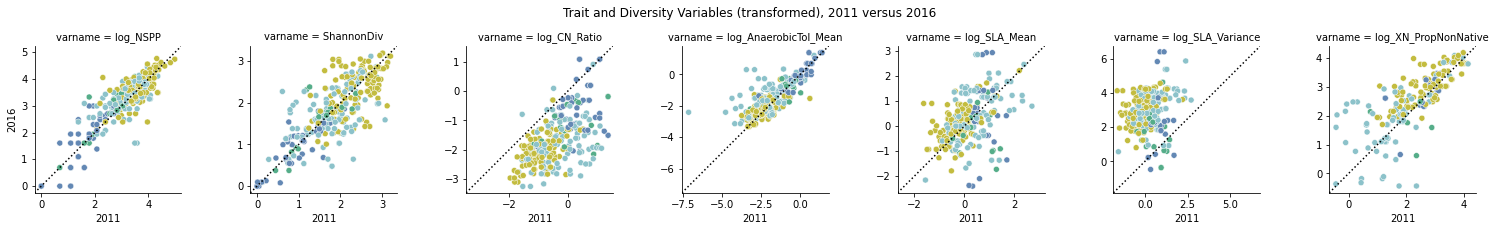

In [11]:
# scatterplot 2011 vs 2016 values for diversity and traits data
# Here we can see a substantial difference between 2011 and 2016 carbon:nitrogen ratio

def plot_twoway_symmetrical(*args, **kwargs):
    sp = sns.scatterplot(*args, **kwargs)
    ax = sp.axes
    if "data" in kwargs:
        x = kwargs["data"][kwargs["x"]]
        y = kwargs["data"][kwargs["y"]]
    else:
        x = kwargs["x"]
        y = kwargs["y"]
    #ax.add_patch(make_ellipse(x=x, y=y, 
    #    facecolor="black", alpha=0.1, type="error", n_std=2))
    ax.set_aspect("equal")
    std_min = min(ax.get_xlim() + ax.get_ylim())
    std_max = max(ax.get_xlim() + ax.get_ylim())
    std_lim = (std_min, std_max)
    ax.set_xlim(std_lim)
    ax.set_ylim(std_lim)
    sns.lineplot(ax=ax, color="black", linestyle=":", x=std_lim, y=std_lim)
    sns.despine(ax=ax)
    return sp

d = sites.stack("year").set_index("WetlandCat", append=True).loc[idx[:, :, "2011":"2016"]][["log_NSPP", "ShannonDiv", "log_CN_Ratio", "log_AnaerobicTol_Mean", "log_SLA_Mean", "log_SLA_Variance", "log_XN_PropNonNative"]].stack("varname").unstack("year").reset_index()
g = sns.FacetGrid(data=d, col="varname", sharex=False, sharey=False)
g.map_dataframe(plot_twoway_symmetrical, x="2011", y="2016", hue="WetlandCat", ci=False, palette=catcolors)
#g.add_legend()
g.set_axis_labels(x_var="2011", y_var="2016")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Trait and Diversity Variables (transformed), 2011 versus 2016")
plt.show()

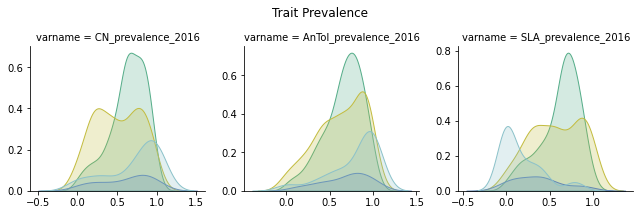

In [12]:
# Histograms of trait prevalence

d = flatten_columns(sites).set_index("WetlandCat_2011", append=True)[["CN_prevalence_2016", "AnTol_prevalence_2016", "SLA_prevalence_2016"]].stack("varname").rename("value").reset_index()
g = sns.FacetGrid(data=d, col="varname", sharex=False, sharey=False, margin_titles=True)
#g.map_dataframe(sns.histplot, x="value", bins=25, stat="density")
g.map_dataframe(sns.kdeplot, x="value", hue="WetlandCat_2011", palette=catcolors, shade=True)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Trait Prevalence")
plt.show()

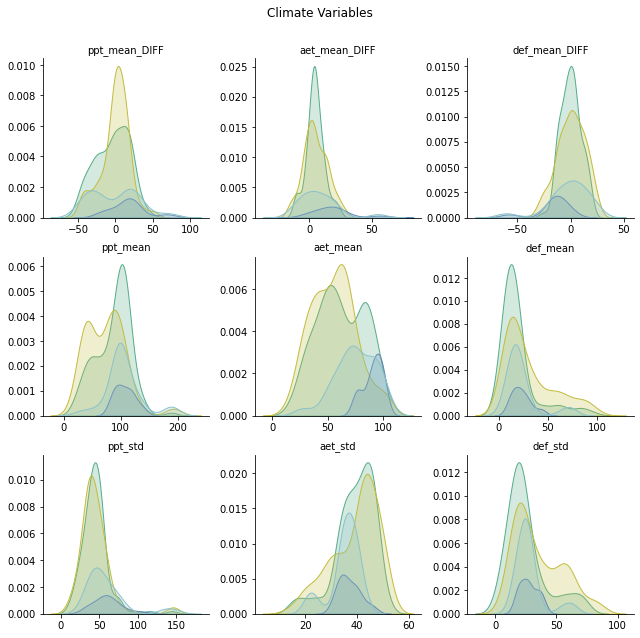

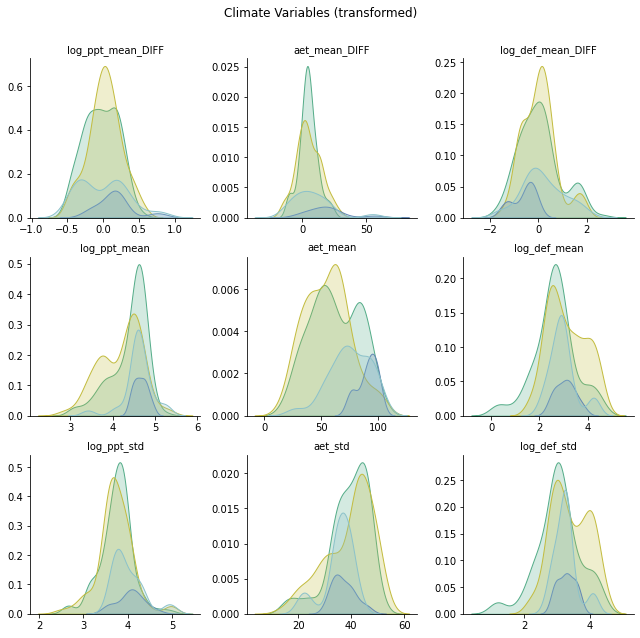

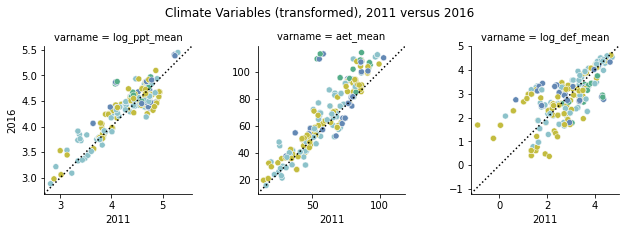

In [13]:
# histograms of terraclimate data

# first row (*_mean_DIFF) is 2016 annual mean minus 2011 annual mean (diffs taken after log transform where applicable)
# second row (*_mean) is long-term (2011-2016) mean of annual means for each of these years
# third row (*_std) is long-term (2011-2016) mean of annual std devs for each of these years

d = flatten_columns(sites).set_index("WetlandCat_2011", append=True)[["ppt_mean_DIFF", "aet_mean_DIFF", "def_mean_DIFF", "ppt_mean", "aet_mean", "def_mean", "ppt_std", "aet_std", "def_std"]].stack("varname").rename("value").reset_index()
g = sns.FacetGrid(data=d, col="varname", col_wrap=3, sharex=False, sharey=False, margin_titles=True)
#g.map_dataframe(sns.histplot, x="value", bins=25, stat="density")
g.map_dataframe(sns.kdeplot, x="value", hue="WetlandCat_2011", palette=catcolors, shade=True)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Climate Variables")
g.set_titles("{col_name}")
plt.show()

d = flatten_columns(sites).set_index("WetlandCat_2011", append=True)[["log_ppt_mean_DIFF", "aet_mean_DIFF", "log_def_mean_DIFF", "log_ppt_mean", "aet_mean", "log_def_mean", "log_ppt_std", "aet_std", "log_def_std"]].stack("varname").rename("value").reset_index()
g = sns.FacetGrid(data=d, col="varname", col_wrap=3, sharex=False, sharey=False, margin_titles=True)
#g.map_dataframe(sns.histplot, x="value", bins=25, stat="density")
g.map_dataframe(sns.kdeplot, x="value", hue="WetlandCat_2011", palette=catcolors, shade=True)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Climate Variables (transformed)")
g.set_titles("{col_name}")
plt.show()

# scatterplot 2011 vs 2016 values for terraclimate data

d = sites.stack("year").set_index("WetlandCat", append=True).loc[idx[:, :, "2011":"2016"]][["log_ppt_mean", "aet_mean", "log_def_mean"]].stack("varname").unstack("year").reset_index()
g = sns.FacetGrid(data=d, col="varname", sharex=False, sharey=False)
g.map_dataframe(plot_twoway_symmetrical, x="2011", y="2016", hue="WetlandCat", ci=False, palette=catcolors)
#g.add_legend()
g.set_axis_labels(x_var="2011", y_var="2016")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Climate Variables (transformed), 2011 versus 2016")
plt.show()

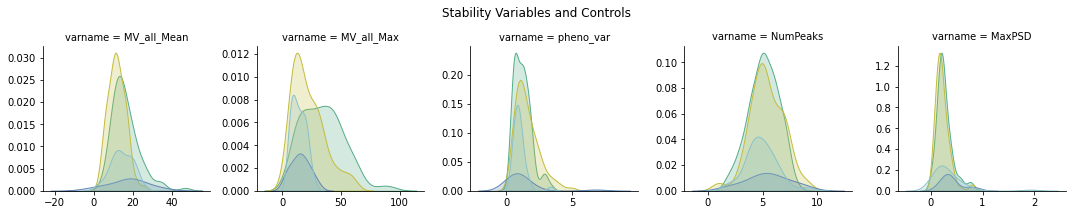

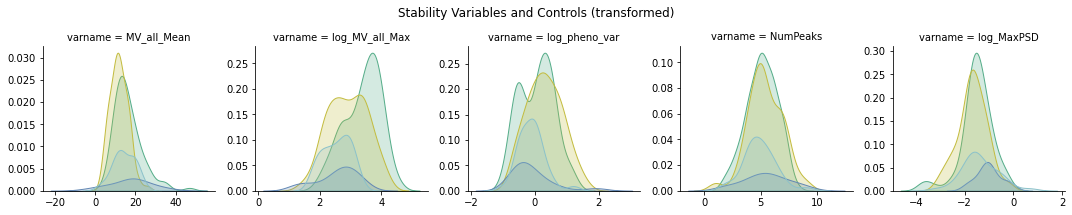

In [14]:
# histograms of stability

d = flatten_columns(sites).set_index("WetlandCat_2011", append=True)[["MV_all_Mean", "MV_all_Max", "pheno_var", "NumPeaks", "MaxPSD"]].stack("varname").rename("value").reset_index()
g = sns.FacetGrid(data=d, col="varname", sharex=False, sharey=False, margin_titles=True)
#g.map_dataframe(sns.histplot, x="value", bins=25, stat="density")
g.map_dataframe(sns.kdeplot, x="value", hue="WetlandCat_2011", palette=catcolors, shade=True)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Stability Variables and Controls")
plt.show()

d = flatten_columns(sites).set_index("WetlandCat_2011", append=True)[["MV_all_Mean", "log_MV_all_Max", "log_pheno_var", "NumPeaks", "log_MaxPSD"]].stack("varname").rename("value").reset_index()
g = sns.FacetGrid(data=d, col="varname", sharex=False, sharey=False, margin_titles=True)
#g.map_dataframe(sns.histplot, x="value", bins=25, stat="density")
g.map_dataframe(sns.kdeplot, x="value", hue="WetlandCat_2011", palette=catcolors, shade=True)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Stability Variables and Controls (transformed)")
plt.show()

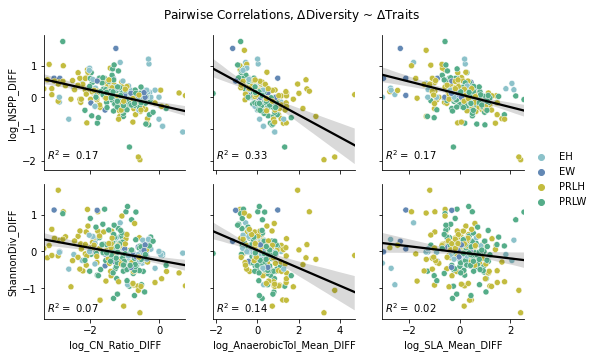

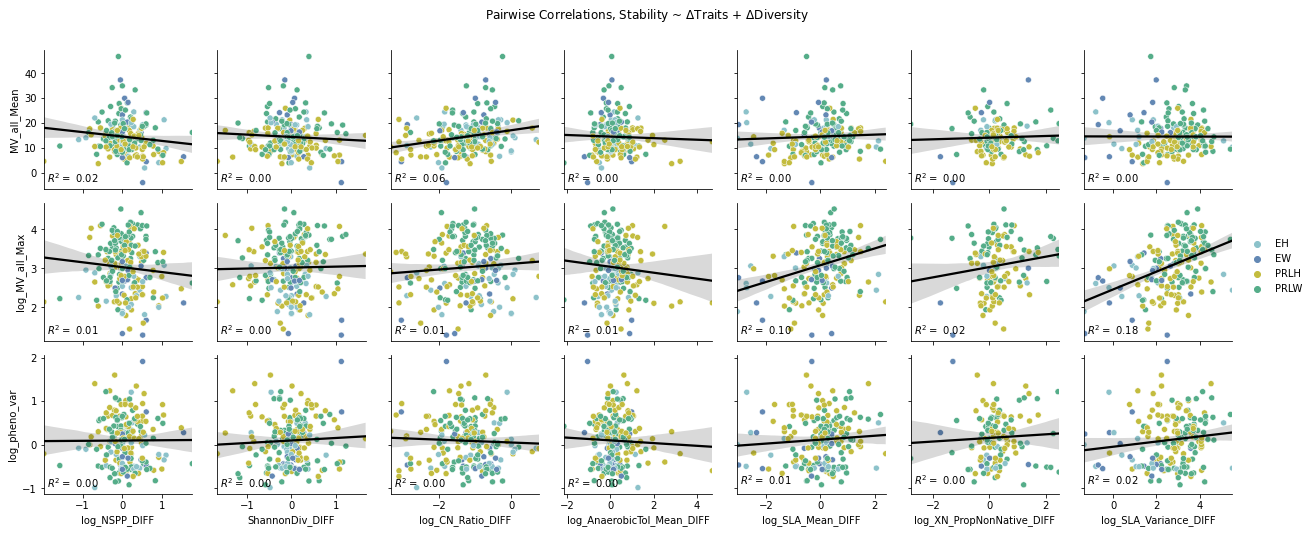

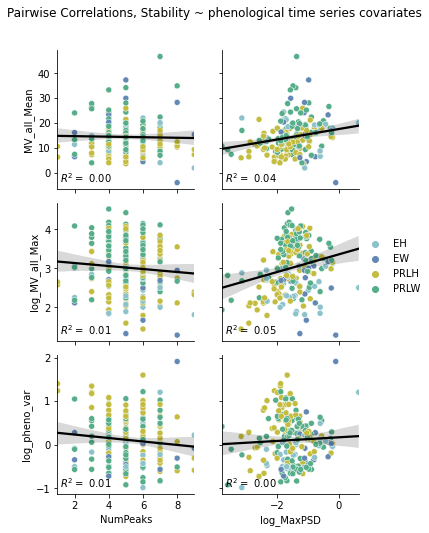

In [29]:
# exploratory scatterplots / simple regressions of key variables

def plot_twoway_reg(hue, palette, *args, **kwargs):
    # create the scatterplot
    g = sns.scatterplot(x=kwargs["x"], y=kwargs["y"], hue=hue, palette=palette)
    h = sns.regplot(x=kwargs["x"], y=kwargs["y"], scatter=False, ax=g.axes, color="black")
    # calculate and annotate R squared
    ser = pd.concat([kwargs["x"], kwargs["y"]], axis="columns").dropna()
    r, p = scipy.stats.pearsonr(ser.iloc[:, 0], ser.iloc[:, 1])
    g.axes.annotate(s=f" $R^2=${r**2: 0.2f}", xy=ser.apply(np.min, axis=0))
    return g.axes

d = flatten_columns(sites)

g = sns.PairGrid(data=d, y_vars=["log_NSPP_DIFF", "ShannonDiv_DIFF"], x_vars=["log_CN_Ratio_DIFF", "log_AnaerobicTol_Mean_DIFF", "log_SLA_Mean_DIFF"])
g.map_offdiag(plot_twoway_reg, hue=d["WetlandCat_2016"], palette=catcolors)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Pairwise Correlations, $\Delta$Diversity ~ $\Delta$Traits")
g.add_legend()
plt.show()

g = sns.PairGrid(data=d, y_vars=["MV_all_Mean", "log_MV_all_Max", "log_pheno_var"], x_vars=["log_NSPP_DIFF", "ShannonDiv_DIFF", "log_CN_Ratio_DIFF", "log_AnaerobicTol_Mean_DIFF", "log_SLA_Mean_DIFF", "log_XN_PropNonNative_DIFF", "log_SLA_Variance_DIFF"])
g.map_offdiag(plot_twoway_reg, hue=d["WetlandCat_2016"], palette=catcolors)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Pairwise Correlations, Stability ~ $\Delta$Traits + $\Delta$Diversity")
g.add_legend()
plt.show()

g = sns.PairGrid(data=d, y_vars=["MV_all_Mean", "log_MV_all_Max", "log_pheno_var"], x_vars=["NumPeaks", "log_MaxPSD"])
g.map_offdiag(plot_twoway_reg, hue=d["WetlandCat_2016"], palette=catcolors)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Pairwise Correlations, Stability ~ phenological time series covariates")
g.add_legend()
plt.show()

# Modeling

## Function setup

For exploratory regressions, `statsmodels` can be used as below:

In [17]:
# R-style formula API: 
reg = smf.ols(data=flatten_columns(sites), formula="log_NSPP_DIFF ~ log_CN_Ratio_DIFF + log_AnaerobicTol_Mean_DIFF + log_SLA_Mean_DIFF").fit(cov_type="HC0")
print(reg.summary2())

# matrix API for more control:
y_var = "log_NSPP_DIFF"
X_vars = ["log_CN_Ratio_DIFF", "log_AnaerobicTol_Mean_DIFF", "log_SLA_Mean_DIFF"]
dmat = flatten_columns(sites)[[y_var] + X_vars].dropna()
y = dmat[y_var]
X = sm.add_constant(dmat[X_vars])
reg = sm.OLS(endog=y, exog=X).fit(cov_type="HC0")
print(reg.summary2())

                     Results: Ordinary least squares
Model:                 OLS                 Adj. R-squared:        0.487   
Dependent Variable:    log_NSPP_DIFF       AIC:                   146.3579
Date:                  2021-08-16 21:00    BIC:                   160.6006
No. Observations:      260                 Log-Likelihood:        -69.179 
Df Model:              3                   F-statistic:           42.59   
Df Residuals:          256                 Prob (F-statistic):    2.33e-22
R-squared:             0.493               Scale:                 0.10124 
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                  -0.0601   0.0528 -1.1388 0.2548 -0.1636  0.0434
log_CN_Ratio_DIFF          -0.1716   0.0363 -4.7255 0.0000 -0.2428 -0.1004
log_AnaerobicTol_Mean_DIFF -0.2977   0.0485 -6.

However, since we are looping through many different models, custom functions are defined for executing regression and reporting results:

In [18]:
def exec_ols(y: pd.Series, X: pd.DataFrame, standardize=True):
    """ Returns a fitted statsmodels regression model 
        given X and Y design matrices. """
    dmat = pd.concat([y, X], axis="columns").dropna()
    if standardize:
        dmat[:] = scale(dmat[:]) # standardize the variables and don't fit intercept
        reg = sm.OLS(endog=dmat.iloc[:, 0], exog=dmat.iloc[:, 1:]).fit(cov_type="HC0")
    else:
        reg = sm.OLS(endog=dmat.iloc[:, 0], exog=dmat.iloc[:, 1:].assign(intercept=1)).fit(cov_type="HC0")
    return reg

def fit_models(df: pd.DataFrame, ys: list, Xs: dict) -> pd.Series:
    """ Return a series of fitted statsmodels regression models
        given a dataframe, a list of y variables, and a dict of named lists of X variables. """

    regs = [[exec_ols(y = df[y], X = df[Xs[m]]) for m in Xs] for y in ys]
    regs = pd.DataFrame(regs, index=ys, columns=Xs).stack().rename("model")
    return regs

def output_results(regs: pd.Series) -> pd.DataFrame:
    """ Returns a dataframe of formatted results (coefficients, significance indicaotrs, R squared and AIC)
        given a series of fitted statsmodels regression models."""

    out_rsq = regs.apply(lambda x: x.rsquared).rename_axis(["y", "model"]).rename("_outputs")
    out_aic = regs.apply(lambda x: x.aic).rename_axis(["y", "model"]).rename("_outputs")

    params = regs.apply(lambda x: x.params).rename_axis(["variable"], axis="columns").rename_axis(["y", "model"])
    pvalues = regs.apply(lambda x: x.pvalues).rename_axis(["variable"], axis="columns").rename_axis(["y", "model"])
    
    # reformat for printing
    params = params.applymap(lambda x: f"+{abs(x):0.2f}" if x>0 else f"−{abs(x):0.2f}" if x<0 else "—" if x==0 else "").applymap(lambda x: "" if x=="nan" else x)
    pvalues = pvalues.applymap(lambda x: "***" if x<0.01 else "**" if x<0.05 else "*" if x<0.1 else "").applymap(lambda x: "" if x=="nan" else x)

    if "intercept" in params.columns:
        varnames = list(params.columns.drop("intercept")) + ["intercept"] + ["_outputs"]
    else:
        varnames = list(params.columns) + ["_outputs"]
    varnames_dtype = pd.CategoricalDtype(categories=reversed(varnames), ordered=True)
    params.columns = params.columns.astype(varnames_dtype)
    pvalues.columns = pvalues.columns.astype(varnames_dtype)

    return (pd.concat([params.T.assign(output="coeff"), 
                pvalues.T.assign(output="P"), 
                pd.DataFrame(out_rsq).T.assign(output="R2_adj"),
                pd.DataFrame(out_aic).T.assign(output="AIC"),
                ])
            .set_index(["output"], append=True)
            .sort_index(level=0, ascending=False)
            .fillna("")
            )

def test_vif(df: pd.DataFrame, Xs: list, sqrt: bool=True) -> pd.DataFrame:
    """ Tests for multicollinearity given a dataframe and list of X vars,
        returning results in a dataframe format. """
    def qvif(d):
        v = [variance_inflation_factor(d.values, i) for i in range(d.shape[1])]
        return pd.Series(v, index = d.columns)
    vif = pd.DataFrame({k: qvif(df[Xs[k]].dropna()) for k in Xs})
    vif = vif.reindex(vif.max(axis="columns").sort_values(ascending=False).index)
    if sqrt:
        return np.sqrt(vif)
    else:
        return vif

def test_sked(regs: list) -> pd.DataFrame:
    """ Tests for heteroskedasticity given a list or series of fitted statsmodels regression models,
        returning lagrange multiplier statistics in dataframe format. """
    s = regs.apply(lambda m: het_breuschpagan(m.resid, m.model.exog))
    hbp = pd.DataFrame.from_dict(dict(zip(s.index, s.values)))
    hbp.index = ["LMS", "P(LMS)", "F", "P(F)"]
    return hbp

Additional functions for executing lasso regression and feature selection:

In [19]:
def lasso_refit(df: pd.DataFrame, y_var: str, X_vars: list, 
                alpha: float=1.0, zero_tol: float=0.01) -> tuple:
    """ Given a dataframe, a list of y variables, and a dict of named lists of X variables:
        (a) fits an OLS model on standardized data
        (b) fits a lasso-regularized OLS model on standardized data given alpha, zero_tol params
        (c) uses only the variables that produced a non-zero coefficient in (b)
            to re-fit an ordinary OLS model
        and returns a tuple containing statsmodels regression models for (a), (b), (c) """

    dmat = df[[y_var] + X_vars].copy().dropna()
    dmat[:] = scale(dmat[:])
    reg = sm.OLS(endog=dmat[y_var], exog=dmat[X_vars]).fit(cov_type="HC0")
    reg_lasso = sm.OLS(endog=dmat[y_var], exog=dmat[X_vars]).fit_regularized(method="sqrt_lasso", alpha=alpha, zero_tol=zero_tol)
    reg_lasso_params = reg_lasso.params.loc[np.absolute(reg_lasso.params) > zero_tol]
    
    if len(reg_lasso_params) > 0:
        reg_refit = sm.OLS(endog=dmat[y_var], exog=dmat[reg_lasso_params.index]).fit(cov_type="HC0")
    else:
        reg_refit = None
    
    return (reg, reg_lasso, reg_refit)

def exec_lasso(df: pd.DataFrame, y_var: str, X_vars: list):
    """ Given a dataframe and list of X variables,
        loops through lasso regressions under a range of alpha parameters, 
        and returns the results of the refitted regression that minimized AIC."""

    regs = pd.Series({a: lasso_refit(df, y_var, X_vars, alpha=a) for a in np.arange(1,100)})

    def get_aic(reg):
        try: 
            aic = reg.aic
        except AttributeError:
            aic = np.nan
        return aic

    alpha_optimized = regs.apply(lambda x: get_aic(x[2])).idxmin()
    
    return regs.loc[alpha_optimized][2]

def fit_models_lasso(df: pd.DataFrame, ys: list, Xs: dict) -> pd.DataFrame:
    """ Given a dataframe, a list of y variables, and a dict of named lists of X variables,
        returns a series of fitted statsmodels regression models,
        with variable lists optimized iteratively using exec_lasso() """

    regs = [[exec_lasso(df, y, Xs[m]) for m in Xs] for y in ys]
    regs = pd.DataFrame(regs, index=ys, columns=Xs).stack().rename("model")
    return regs

Function for plotting results:

In [20]:
def plot_estimates(reg, alpha=0.05):
    """ Given a statsmodels regression model, plots coefficient estimates
        showing error bars at the specified level of statistical significance. """
    d = pd.concat([reg.params, reg.HC0_se, reg.conf_int(alpha=alpha)], axis="columns").rename_axis("variable")
    d.columns = ["param", "se", "ci_min", "ci_max"]
    tcrit = scipy.stats.t.ppf(1 - alpha, reg.df_resid)
    d = (d
        .sort_values("param")
        .reset_index()
        .assign(ci = lambda d: tcrit * d["se"])
        .assign(significant = lambda d: np.sign(d["param"] + d["ci"]) == np.sign(d["param"] - d["ci"]))
        )
    fig, ax = plt.subplots()
    plt.errorbar(y=d["variable"], x=d["param"], xerr=d["ci"]*~d["significant"], ls="none", color="#AAAAAA")
    plt.errorbar(y=d["variable"], x=d["param"], xerr=d["ci"]*d["significant"], ls="none", color="#000000")
    sns.pointplot(ax=ax, y=d["variable"], x=d["param"], hue=d["significant"], join=False, palette=["#AAAAAA", "#000000"])
    plt.axvline(x=0, ls=":", color="black")
    plt.xlabel("standardized parameter estimate")
    plt.ylabel("")
    sns.despine(ax=ax, trim=True)
    fig.set_size_inches(8, 8)
    ax.legend(title=f"P<{alpha}")
    return ax

## Model specifications

First, define categories of variable lists to use, and combinations of these variables into models

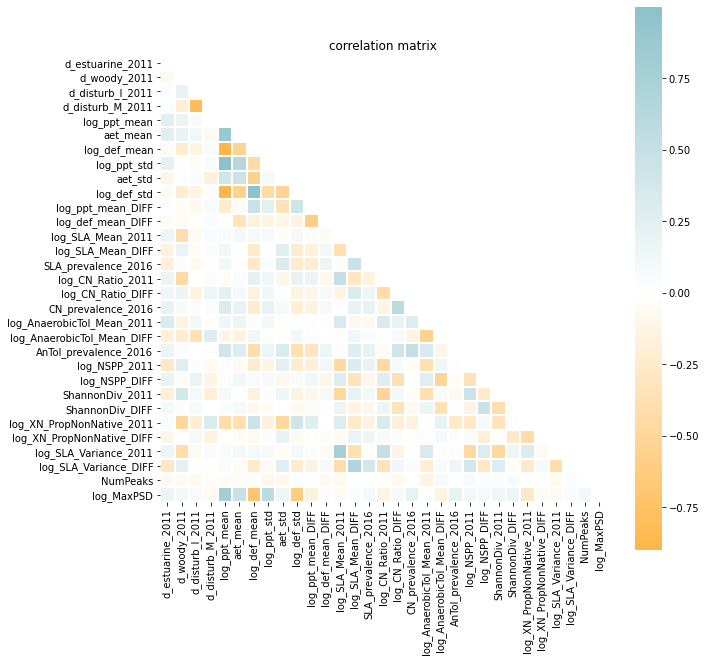

In [22]:
# GROUPS OF X VARIABLES

vars_attributes = ["d_estuarine_2011", "d_woody_2011"]
vars_disturb = ["d_disturb_I_2011", "d_disturb_M_2011"]

vars_climate = ["log_ppt_mean", "aet_mean", "log_def_mean"]
vars_climate_variability = ["log_ppt_std", "aet_std", "log_def_std"]
vars_dif_climate = ["log_ppt_mean_DIFF", "log_def_mean_DIFF"]

vars_traits_SL = ["log_SLA_Mean_2011", "log_SLA_Mean_DIFF", "SLA_prevalence_2016"]
vars_traits_CN = ["log_CN_Ratio_2011", "log_CN_Ratio_DIFF", "CN_prevalence_2016"]
vars_traits_AT = ["log_AnaerobicTol_Mean_2011", "log_AnaerobicTol_Mean_DIFF", "AnTol_prevalence_2016"]
vars_traits = vars_traits_SL + vars_traits_CN + vars_traits_AT

vars_diversity_SR = ["log_NSPP_2011", "log_NSPP_DIFF"]
vars_diversity_SH = ["ShannonDiv_2011", "ShannonDiv_DIFF"]
vars_diversity_NS = ["log_XN_PropNonNative_2011", "log_XN_PropNonNative_DIFF"] 
vars_diversity_VS = ["log_SLA_Variance_2011", "log_SLA_Variance_DIFF"]
vars_diversity = vars_diversity_SR + vars_diversity_SH + vars_diversity_NS + vars_diversity_VS

vars_stab_ts = ["NumPeaks", "log_MaxPSD"]
vars_stability = ["MV_all_Mean", "log_MV_all_Max", "log_pheno_var"]

###############################################
# NAMED MODELS VIA COMBINATIONS OF THESE GROUPS

# X variables for diversity models
dmodels2 = {
    "none": vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate, 

    "SL":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_SL,
    "CN":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_CN,
    "AT":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_AT, 

    "full": vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits, 
}

# X variables for stability models
smodels2 = {
    "none": vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate, 

    "SL":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_SL,
    "CN":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_CN,
    "AT":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_AT, 
    
    "SR":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_diversity_SR,
    "SH":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_diversity_SH,
    "NS":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_diversity_NS,
    "VS":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_diversity_VS,
    
    "TS":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_stab_ts,

    "full": vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits + vars_diversity + vars_stab_ts,
}

######################################

# DEFINE FLATTENED DATAFRAME (just as a shortcut for future access) 
df = flatten_columns(sites)

######################################

# PLOT CORRELATION MATRIX
yv = ["log_NSPP_DIFF", "ShannonDiv_DIFF", "MV_all_Mean", "log_MV_all_Max", "log_pheno_var"]
xv = dmodels2["full"] + [x for x in smodels2["full"] if x not in dmodels2["full"]]
df_scaled = df.copy().select_dtypes(include=np.number)
df_scaled[:] = scale(df_scaled[:])
x_corr = pd.DataFrame(np.cov(df_scaled[xv].dropna().T), index=xv, columns=xv)
fig, ax = plt.subplots()
sns.heatmap(x_corr, mask=np.triu(np.ones_like(x_corr, dtype=bool)), 
            ax=ax, xticklabels=True, yticklabels=True, 
            cmap=diverging_cmap, center=0, cbar=True, linewidths=1, linecolor="white")
fig.set_size_inches(10,10)
ax.set_aspect('equal')
ax.set_title("correlation matrix")
plt.show()

## Loop and optimize
Finally we can run through the models and assemble output. The summary table is also exported as CSV for import to Word via Excel. Four different model runs are undertaken and summary tables generated:
- Diversity models via OLS
- Diversity models via lassoed OLS
- Stability models via OLS
- Stability models via lassoed OLS

In output tables:
- rows = individual X variables (reporting out their coefficients and statistical significance)
    - \*** P < 0.01
    - \** P < 0.05
    - \* P < 0.1
- columns = y variables → named combinations of X variables

y                                 log_NSPP_DIFF         ... ShannonDiv_DIFF       
model                                      none     SL  ...              AT   full
                           output                       ...                       
d_estuarine_2011           coeff          +0.03  +0.06  ...           +0.07  +0.05
                           P                            ...                       
d_woody_2011               coeff          −0.02  +0.05  ...           −0.12  +0.07
                           P                            ...              **       
d_disturb_I_2011           coeff          +0.08  +0.10  ...           −0.04  +0.02
                           P                            ...                       
d_disturb_M_2011           coeff          −0.02  +0.02  ...           +0.03  +0.10
                           P                            ...                       
log_ppt_mean               coeff          +0.01  −0.25  ...           +0.15  +0.25
                           P                            ...                       
aet_mean                   coeff          +0.04  +0.16  ...           +0.12  −0.07
                           P                            ...                       
log_def_mean               coeff          −0.23  −0.92  ...           −0.13  −0.41
                           P                        **  ...                       
log_ppt_std                coeff          −0.06  +0.01  ...           −0.20  −0.15
                           P                            ...                       
aet_std                    coeff          −0.13  −0.18  ...           +0.03  +0.03
                           P                        **  ...                       
log_def_std                coeff          +0.25  +0.75  ...           +0.21  +0.49
                           P                        **  ...                       
log_ppt_mean_DIFF          coeff          +0.03  +0.04  ...           +0.15  +0.08
                           P                            ...                       
log_def_mean_DIFF          coeff          −0.09  +0.02  ...           +0.15  +0.08
                           P                            ...                       
log_SLA_Mean_2011          coeff                 +0.25  ...                  +0.22
                           P                       ***  ...                      *
log_SLA_Mean_DIFF          coeff                 −0.36  ...                  +0.15
                           P                       ***  ...                      *
SLA_prevalence_2016        coeff                 +0.12  ...                  −0.22
                           P                            ...                    ***
log_CN_Ratio_2011          coeff                        ...                  −0.31
                           P                            ...                       
log_CN_Ratio_DIFF          coeff                        ...                  −0.63
                           P                            ...                    ***
CN_prevalence_2016         coeff                        ...                  +0.17
                           P                            ...                       
log_AnaerobicTol_Mean_2011 coeff                        ...           −0.26  +0.08
                           P                            ...              **       
log_AnaerobicTol_Mean_DIFF coeff                        ...           −0.51  −0.16
                           P                            ...             ***       
AnTol_prevalence_2016      coeff                        ...           +0.02  +0.10
                           P                            ...                       
_outputs                   R2_adj          0.04   0.26  ...            0.18   0.28
                           AIC           826.15 688.38  ...          786.03 687.86

[44 rows x 10 columns]

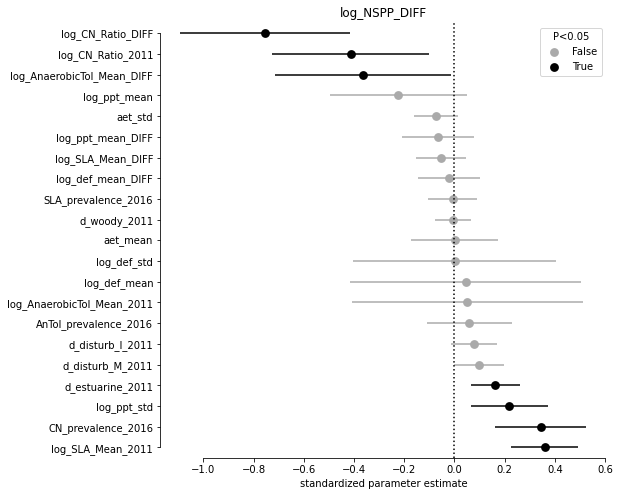

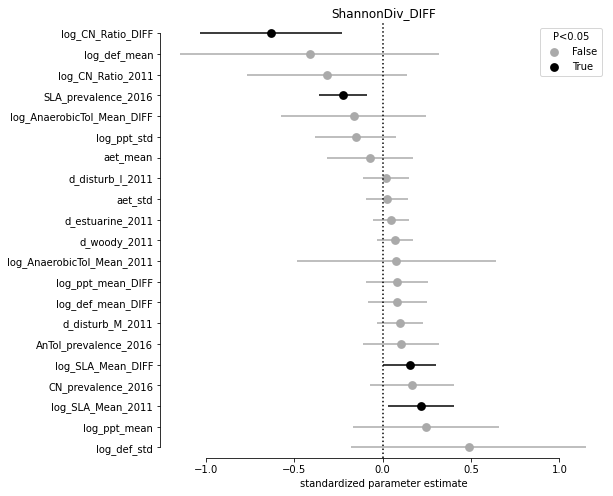

In [23]:
# DIVERSITY MODEL
ys = ["log_NSPP_DIFF", "ShannonDiv_DIFF"]
regs2_diversity = fit_models(df=df, ys=ys, Xs=dmodels2)
for y in ys:
    plot_estimates(regs2_diversity.loc[y].loc["full"]).set_title(y)
regs2_diversity_results = output_results(regs2_diversity)
regs2_diversity_results.to_csv("regs2_diversity.csv")
regs2_diversity_results

y                                 log_NSPP_DIFF         ... ShannonDiv_DIFF       
model                                      none     SL  ...              AT   full
                           output                       ...                       
d_estuarine_2011           coeff                        ...                       
                           P                            ...                       
d_woody_2011               coeff                        ...                       
                           P                            ...                       
d_disturb_I_2011           coeff          +0.09  +0.12  ...                       
                           P                        **  ...                       
d_disturb_M_2011           coeff                        ...                  +0.07
                           P                            ...                       
log_ppt_mean               coeff                        ...                       
                           P                            ...                       
aet_mean                   coeff                        ...                       
                           P                            ...                       
log_def_mean               coeff                        ...                       
                           P                            ...                       
log_ppt_std                coeff                        ...                       
                           P                            ...                       
aet_std                    coeff          −0.14  −0.13  ...                       
                           P                 **     **  ...                       
log_def_std                coeff                        ...                       
                           P                            ...                       
log_ppt_mean_DIFF          coeff                        ...                  +0.00
                           P                            ...                       
log_def_mean_DIFF          coeff          −0.11         ...                  +0.08
                           P                  *         ...                       
log_SLA_Mean_2011          coeff                 +0.22  ...                  +0.22
                           P                       ***  ...                     **
log_SLA_Mean_DIFF          coeff                 −0.36  ...                  +0.16
                           P                       ***  ...                      *
SLA_prevalence_2016        coeff                 +0.13  ...                  −0.23
                           P                            ...                    ***
log_CN_Ratio_2011          coeff                        ...                  −0.28
                           P                            ...                     **
log_CN_Ratio_DIFF          coeff                        ...                  −0.55
                           P                            ...                    ***
CN_prevalence_2016         coeff                        ...                  +0.15
                           P                            ...                       
log_AnaerobicTol_Mean_2011 coeff                        ...                       
                           P                            ...                       
log_AnaerobicTol_Mean_DIFF coeff                        ...           −0.37  −0.26
                           P                            ...             ***    ***
AnTol_prevalence_2016      coeff                        ...                  +0.14
                           P                            ...                      *
_outputs                   R2_adj          0.04   0.24  ...            0.14   0.27
                           AIC           809.60 676.79  ...          771.96 672.71

[44 rows x 10 columns]

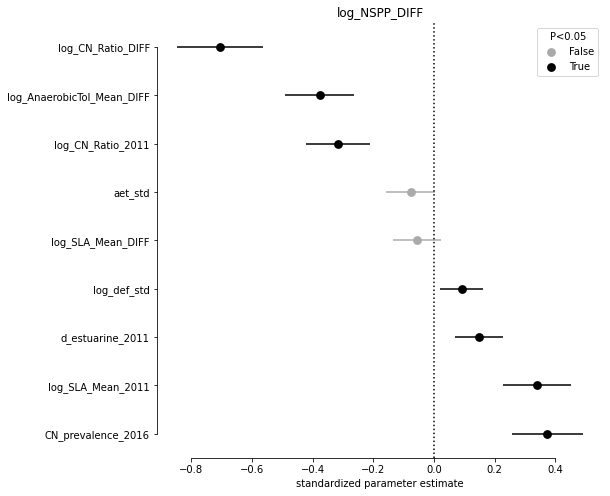

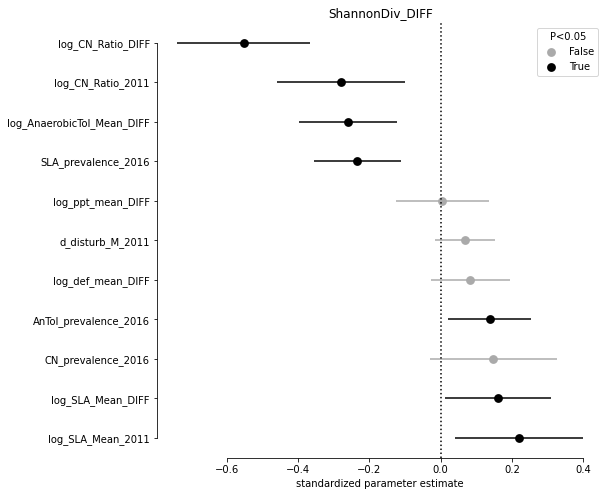

In [24]:
# DIVERSITY MODEL with lasso regularization for feature selection
ys = ["log_NSPP_DIFF", "ShannonDiv_DIFF"]
regs2_diversity_lasso = fit_models_lasso(df=df, ys=ys, Xs=dmodels2)
for y in ys:
    plot_estimates(regs2_diversity_lasso.loc[y].loc["full"]).set_title(y)
regs2_diversity_lasso_results = output_results(regs2_diversity_lasso).reindex(regs2_diversity_results.index, fill_value="")
regs2_diversity_lasso_results.to_csv("regs2_diversity_lasso.csv")
regs2_diversity_lasso_results

y                       MV_all_Mean                ... log_pheno_var              
model                          none     SL     CN  ...            VS     TS   full
                 output                            ...                            
d_estuarine_2011 coeff        −0.09  +0.02  −0.08  ...         +0.11  +0.09  +0.12
                 P                                 ...                            
d_woody_2011     coeff        +0.24  +0.10  +0.16  ...         −0.01  −0.08  +0.15
                 P              ***            **  ...                    *      *
d_disturb_I_2011 coeff        −0.02  −0.12  −0.05  ...         +0.08  +0.02  +0.08
...                             ...    ...    ...  ...           ...    ...    ...
NumPeaks         P                                 ...                            
log_MaxPSD       coeff                             ...                +0.39  +0.41
                 P                                 ...                  ***    ***
_outputs         R2_adj        0.30   0.37   0.35  ...          0.54   0.59   0.66
                 AIC         535.24 473.71 517.25  ...        413.33 430.37 281.09

[64 rows x 30 columns]

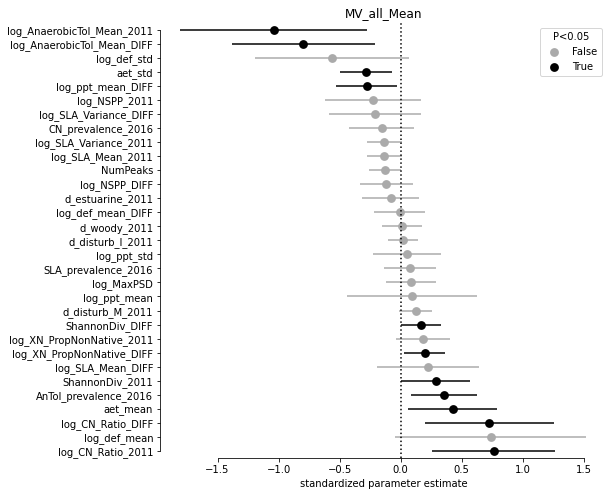

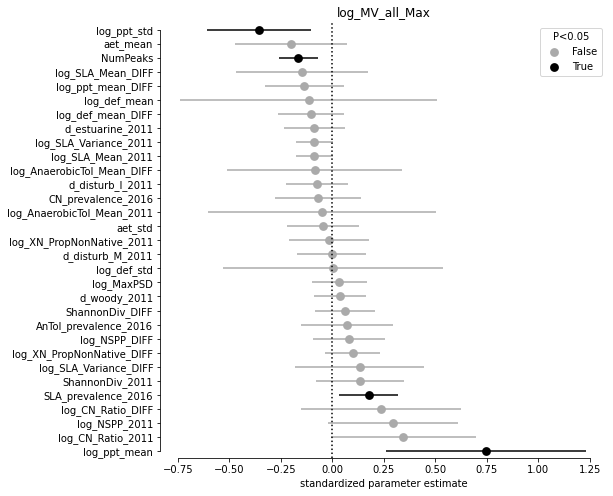

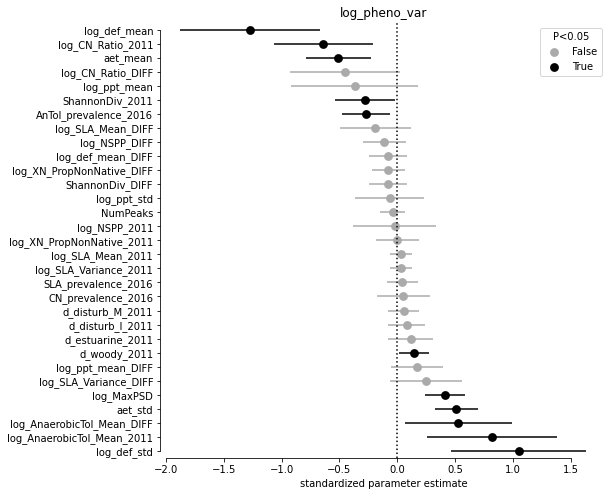

In [25]:
# STABILITY MODEL
ys = ["MV_all_Mean", "log_MV_all_Max", "log_pheno_var"]
regs2_stability = fit_models(df=df, ys=ys, Xs=smodels2)
for y in ys:
    plot_estimates(regs2_stability.loc[y].loc["full"]).set_title(y)
regs2_stability_results = output_results(regs2_stability)
regs2_stability_results.to_csv("regs2_stability.csv")
regs2_stability_results

y                       MV_all_Mean                ... log_pheno_var              
model                          none     SL     CN  ...            VS     TS   full
                 output                            ...                            
d_estuarine_2011 coeff                             ...         +0.13  +0.09       
                 P                                 ...             *              
d_woody_2011     coeff        +0.25  +0.10  +0.16  ...                −0.08       
                 P              ***            **  ...                    *       
d_disturb_I_2011 coeff                             ...                            
...                             ...    ...    ...  ...           ...    ...    ...
NumPeaks         P                                 ...                    *       
log_MaxPSD       coeff                             ...                +0.38  +0.51
                 P                                 ...                  ***    ***
_outputs         R2_adj        0.29   0.34   0.33  ...          0.53   0.59   0.59
                 AIC         527.80 468.18 509.49  ...        406.76 424.90 268.55

[64 rows x 30 columns]

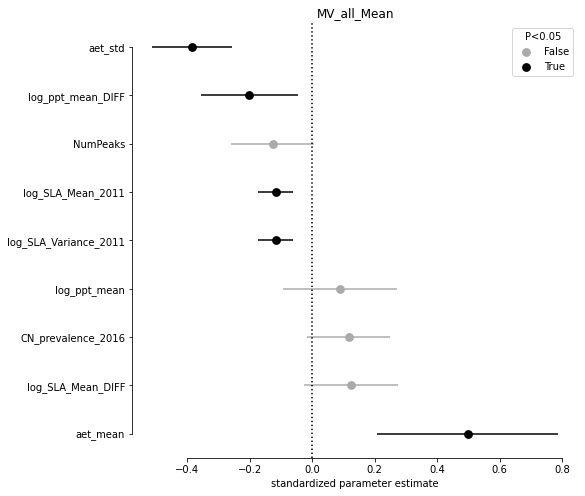

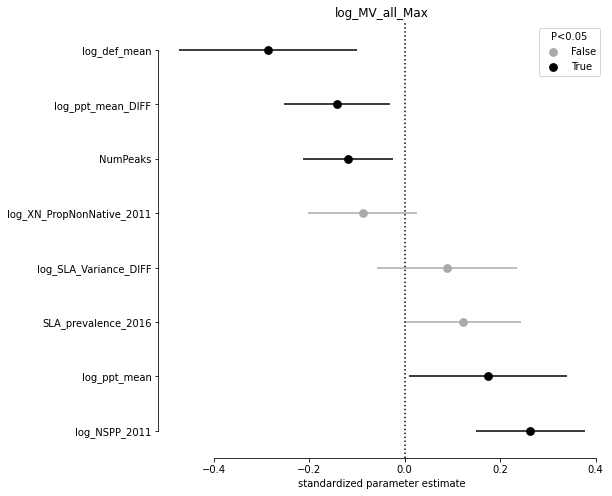

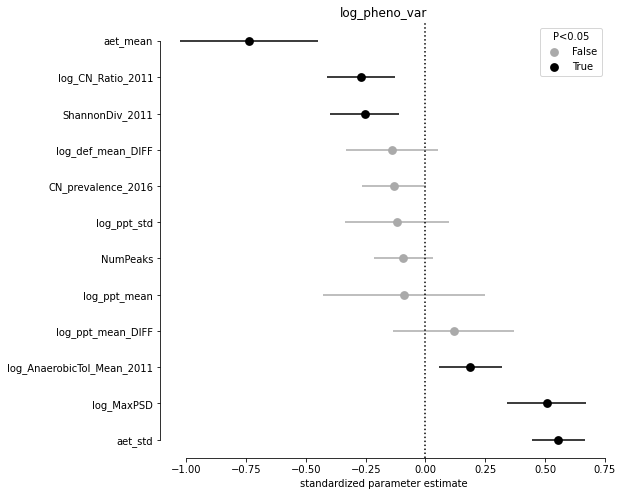

In [26]:
# STABILITY MODEL with lasso regularization for feature selection
ys = ["MV_all_Mean", "log_MV_all_Max", "log_pheno_var"]
regs2_stability_lasso = fit_models_lasso(df=df, ys=ys, Xs=smodels2)
for y in ys:
    plot_estimates(regs2_stability_lasso.loc[y].loc["full"]).set_title(y)
regs2_stability_lasso_results = output_results(regs2_stability_lasso).reindex(regs2_stability_results.index, fill_value="")
regs2_stability_lasso_results.to_csv("regs2_stability_lasso.csv")
regs2_stability_lasso_results

## Alternate outputs

For the "full" models, this is a simplified summary view showing the coefficient estimates colored by t-statistic. This figure is useful for seeing how the sets of predictors vary with different y-variables.

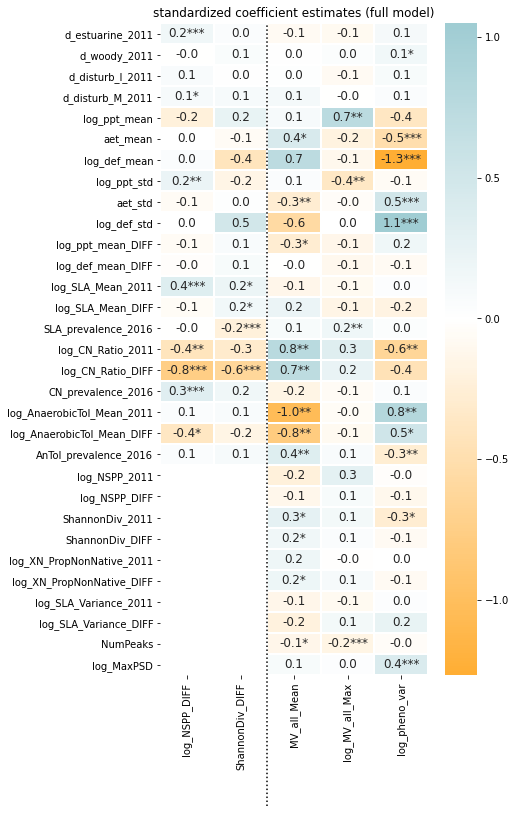

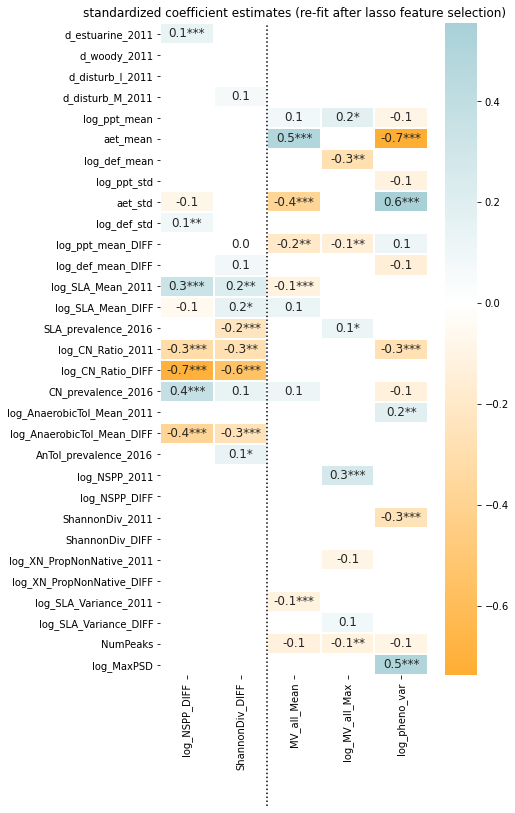

In [27]:
# collect the lists of full variables used for each model
full_model_vars ={
    "log_NSPP_DIFF": dmodels2["full"],
    "ShannonDiv_DIFF": dmodels2["full"],
    "MV_all_Mean": smodels2["full"],
    "log_MV_all_Max": smodels2["full"],
    "log_pheno_var": smodels2["full"],
}

# OLS COEFFICIENTS
full_models = {y: exec_ols(y=df[y], X=df[full_model_vars[y]]) for y in full_model_vars} 
full_model_params = {y: full_models[y].params for y in full_model_vars}
full_model_tvalues = {y: full_models[y].tvalues for y in full_model_vars}
full_model_pvalues = {y: full_models[y].pvalues for y in full_model_vars}

xs = dmodels2["full"] + [x for x in smodels2["full"] if x not in dmodels2["full"]]
full_model_params = pd.concat(full_model_params).unstack().T.reindex(pd.Index(xs))
full_model_tvalues = pd.concat(full_model_tvalues).unstack().T.reindex(pd.Index(xs))
full_model_pvalues = pd.concat(full_model_pvalues).unstack().T.reindex(pd.Index(xs))

significance_indicator = full_model_pvalues.applymap(lambda x: "***" if x<0.01 else "**" if x<0.05 else "*" if x<0.1 else "")
param_labels = full_model_params.applymap(lambda x: f"{x:0.1f}") + significance_indicator
#param_labels = full_model_params.applymap(lambda x: f"{x:{'+' if x>0 else '-'}0.1f}") + significance_indicator

fig, ax = plt.subplots()
sns.heatmap(
            full_model_params, cmap=diverging_cmap, center=0,
            ax=ax, xticklabels=True, yticklabels=True, 
            cbar=True, linewidths=1, linecolor="white",
            annot=param_labels, annot_kws={"size": 12}, fmt="")
ax.axvline(x=2, color="black", ls=":", clip_on=False, ymin=-0.2)
ax.set_title("standardized coefficient estimates (full model)")
fig.set_size_inches(6, 12)
plt.show()

# LASSO COEFFICIENTS
full_models = {y: exec_lasso(df=df, y_var=y, X_vars=full_model_vars[y]) for y in full_model_vars} 
full_model_params = {y: full_models[y].params for y in full_model_vars}
full_model_tvalues = {y: full_models[y].tvalues for y in full_model_vars}
full_model_pvalues = {y: full_models[y].pvalues for y in full_model_vars}

xs = dmodels2["full"] + [x for x in smodels2["full"] if x not in dmodels2["full"]]
full_model_params = pd.concat(full_model_params).unstack().T.reindex(pd.Index(xs))
full_model_tvalues = pd.concat(full_model_tvalues).unstack().T.reindex(pd.Index(xs))
full_model_pvalues = pd.concat(full_model_pvalues).unstack().T.reindex(pd.Index(xs))

significance_indicator = full_model_pvalues.applymap(lambda x: "***" if x<0.01 else "**" if x<0.05 else "*" if x<0.1 else "")
param_labels = full_model_params.applymap(lambda x: f"{x:0.1f}") + significance_indicator
#param_labels = full_model_params.applymap(lambda x: f"{x:{'+' if x>0 else '-'}0.1f}") + significance_indicator

fig, ax = plt.subplots()
sns.heatmap(
            full_model_params, cmap=diverging_cmap, center=0,
            ax=ax, xticklabels=True, yticklabels=True, 
            cbar=True, linewidths=1, linecolor="white",
            annot=param_labels, annot_kws={"size": 12}, fmt="")
ax.axvline(x=2, color="black", ls=":", clip_on=False, ymin=-0.2)
ax.set_title("standardized coefficient estimates (re-fit after lasso feature selection)")
fig.set_size_inches(6, 12)
plt.show()

In [36]:
# This is a quick summary of all R-squared values for the full models

result_outputs = pd.concat([pd.concat({"full": regs2_diversity_results.loc["_outputs"], "lasso": regs2_diversity_lasso_results.loc["_outputs"]}, axis="rows", names=["type", "output"]),
                            pd.concat({"full": regs2_stability_results.loc["_outputs"], "lasso": regs2_stability_lasso_results.loc["_outputs"]}, axis="rows", names=["type", "output"]),], axis="columns")

s = result_outputs.loc["lasso"].loc["R2_adj"].reset_index()
s["y"] = s["y"].astype("category").cat.set_categories(result_outputs.columns.get_level_values("y").unique())
s["model"] = s["model"].astype("category").cat.set_categories(smodels2.keys())
s = s.set_index(["y", "model"]).unstack().T.loc["R2_adj"].fillna("")
s.to_csv("rsquared.csv")
s

y,log_NSPP_DIFF,ShannonDiv_DIFF,MV_all_Mean,log_MV_all_Max,log_pheno_var
model,,,,,
none,0.04,0.02,0.29,0.53,0.51
SL,0.24,0.05,0.34,0.56,0.53
CN,0.41,0.17,0.33,0.56,0.51
AT,0.44,0.14,0.33,0.58,0.53
SR,,,0.33,0.56,0.52
SH,,,0.31,0.54,0.52
NS,,,0.36,0.57,0.51
VS,,,0.34,0.55,0.53
TS,,,0.29,0.53,0.59
